# Figure S4

In [1]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md
import random
from scipy import stats
from scipy.special import logit

## Bio functions
from Bio import AlignIO
from Bio import SeqIO

## Local functions
import sys
sys.path.append("../code/scripts")
import alignment_quality as aq
import chargepatterns as cp
import composition as comp
import crutil
import fractional_charge as fc


## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [2]:
all_aa2 = ['E', 'D', 'K', 'R', 'H', 'Q', 'P', 'N', 'A', 'T',
           'S', 'V', 'G', 'M', 'C', 'I', 'L', 'Y', 'F', 'W']

## S5A

In [3]:
def comp_to_dict(c):
    d = {}
    for i,aa in enumerate(comp.aas):
        d[aa] = c[i]
    return d

In [4]:
aybrah = ['Rhodotorula graminis',
        'Saitoella complicata',
        'Schizosaccharomyces pombe',
        'Aspergillus niger',
        'Neurospora crassa',
        'Trichoderma reesei',
        'Lipomyces starkeyi',
        'Yarrowia lipolytica',
        'Blastobotrys adeninivorans',
        'Nadsonia fulvescens',
        'Ascoidea rubescens',
        'Pachysolen tannophilus',
        'Komagataella phaffii',
        'Kuraishia capsulata',
        'Ogataea arabinofermentans',
        'Ogataea parapolymorpha',
        'Dekkera bruxellensis',
        'Pichia membranifaciens',
        'Pichia kudriavzevii',
        'Babjeviella inositovora',
        'Metschnikowia bicuspidata',
        'Meyerozyma guilliermondii',
        'Debaryomyces hansenii',
        'Scheffersomyces stipitis',
        'Spathaspora passalidarum',
        'Wickerhamomyces anomalus',
        'Cyberlindnera jadinii',
        'Hanseniaspora valbyensis',
        'Kluyveromyces lactis',
        'Lachancea thermotolerans',
        'Zygosaccharomyces rouxii',
        'Saccharomyces cerevisiae',
        'Vanderwaltozyma polyspora']

In [5]:
comp_dict = {}
for species in aybrah:
    name = species.split(' ')
    filepath = '../data/ref_proteomes/' + name[0] + '_' + name[1] + '.fasta'
    prot = []
    for record in SeqIO.parse(filepath, "fasta"):
        prot.append(record)
    
    c = np.zeros(20)
    for orf in prot:
        seq = str(orf.seq).replace('*', '').replace('X', '')
        c = np.add(c, comp.get_composition(seq, comp.aas))
    c = np.divide(c, len(prot))
    d = comp_to_dict(c)
    comp_dict[species] = d

In [6]:
#df3 = pd.DataFrame(columns = ['species', 'AA', 'proportion', 'log.odds'])
df_list = []
for species in aybrah:
    c = comp_dict[species]
    for AA in comp.aas:
        rv = {}
        if species == 'Saccharomyces cerevisiae':
            rv = {'species': species}
        else:
            rv = {'species': 'others'}
        rv['AA'] = AA
        rv['proportion'] = c[AA]
        rv['log.odds'] = logit(rv['proportion'])
        df_list.append(rv)

df3 = pd.DataFrame(df_list)

In [7]:
df3_sc = df3[df3.species == 'Saccharomyces cerevisiae']
df3_nonsc = df3[df3.species != 'Saccharomyces cerevisiae']

In [8]:
all_aa = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
colors = []
for aa in all_aa:
    if aa == 'E' or aa == 'D':
        colors.append(cscheme['neg'])
    elif aa == 'K' or aa == 'R':
        colors.append(cscheme['pos'])
    else:
        colors.append(cscheme['dis'])

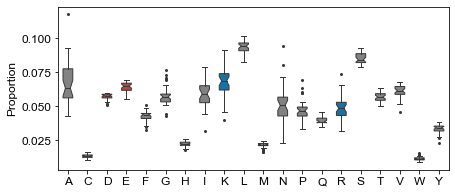

In [16]:
plt.figure(figsize=(7,3))
sns.boxplot(x="AA", y="proportion", data=df3,
            width=0.5, linewidth=1,
            flierprops={"marker": "o", "markersize": 2},
            notch=True, palette=colors)
#sns.swarmplot(x="AA", y="proportion", data=df3_nonsc,
#              color = '.3', linewidth=1, alpha=0.8, size=5)
#sns.swarmplot(x="AA", y="proportion", data=df3_sc,
#              color = 'cyan', linewidth=1, size=8, marker = 'D')
plt.xlabel('')
plt.ylabel('Proportion')
plt.savefig('./plots/FigureS5A.png', dpi=300, bbox_inches='tight')
plt.show()

## S5B

In [18]:
# Data and filepaths
df = pd.read_csv("../data/charged_regions/cr_trimmed_filtered_aflabel.csv", comment='#')

#fdir = "/Volumes/DATA/aybrah/aybrah-all/"
fdir = '/Users/rosalindpan/drummondlab/hcrpaper_data/aybrah-all/'

In [21]:
# Helper functions
def filter_msa(msa, cutoff, how="length"):
    """
    Given an msa, filter out all the entries that are less than a certain length.
    """
    filtered_msa = []
    for record in msa:
        rlen = len(str(record.seq).replace('-', ''))
        if rlen > cutoff:
            filtered_msa.append(record)
            
    return(filtered_msa)

def COV(x, absolute=True):
    """
    Given a interable of values, return the coefficient of variation of those values.
    """
    std = np.sqrt(np.nanvar(x))
    if not absolute:
        return(std / np.nanmean(x))
    else:
        return(std / np.abs(np.nanmean(x)))

In [22]:
# Computation functions

def compute_region_coverage(msa, c=0):
    """
    Given an msa (of a region), count the number of rows with a length greater than a cutoff (c, int).
    The default is to count the number of non-empty rows (c=0). The function assumes that gaps are denoted
    as '-'.
    """
    n_rows = 0
    for record in msa:
        rlen = len(str(record.seq).replace('-',''))
        if rlen > c:
            n_rows += 1
    return(n_rows)

def compute_region_length_var(msa):
    """
    Given an msa, determine the coefficient of variation in the length of the region
    """
    rlens = []
    for record in msa:
        rlen = len(str(record.seq).replace('-',''))
        rlens.append(rlen)
    return(COV(rlens))

In [23]:
# Wrapper
# There are two filters here; one for the length of the region to determine 'presence'; the other is
# whether to filter out msas with very few sequences.

def get_row_length_props(row, filter_cutoff=25, filepath=fdir, connector="-"):
    orf = row['orf']  
    refseq = row['region.seq']
    left_bound = row['left.bound']
    right_bound = row['right.bound']
    # Read MSA for the orf in question
    try:
        msa = AlignIO.read(open(filepath+str(orf)+connector+'aybrah.fa'), "fasta")
        # Get just the region in question
        region_msa = aq.extract_region_msa(msa, left_bound, right_bound, refseq=refseq)
        # Filter the msa for very short and empty regions
        #region_msa = filter_msa(region_msa, cutoff=filter_cutoff)
        msa_len = len(region_msa)
        if msa_len < 5:
            out = np.empty(4)
            out[:] = np.NaN
            return pd.Series(out)
    
        # Calculate region properties
        region_abs_coverage = compute_region_coverage(region_msa, c=filter_cutoff) / 33 # The maximum number of species in the aybrah database
        if region_abs_coverage > 1: # for a few genes there are multiple entries for each species, meaning there may be more than 33 sequences
            region_abs_coverage = 1
        region_rel_coverage = compute_region_coverage(region_msa, c=filter_cutoff) / msa_len
        region_len_var_nofilter = compute_region_length_var(region_msa)
        region_len_var_filter = compute_region_length_var(filter_msa(region_msa, cutoff=filter_cutoff))
    
        return pd.Series([region_abs_coverage, region_rel_coverage, region_len_var_filter, region_len_var_nofilter])
    except:
        out = np.empty(4)
        out[:] = np.NaN
        return pd.Series(out)
    

In [26]:
newcols = df.apply(get_row_length_props, axis=1)
newcols.columns = ['abs_coverage', 'rel_coverage', 'unfiltered_len_var', 'filtered_len_var']
newdf = df.join(newcols)
newdf.head()

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,uni_id,orf_label,kappa,label,abs_coverage,rel_coverage,unfiltered_len_var,filtered_len_var
0,YAL011W,SWC3,626,5,53,RTRSKESSIEQKPASRTRTRSRRGKRGRDDDDDDDDEESDDAYDEVGND,49,0.017593,0.591837,P31376,verified,0.539053,disordered,0.454545,0.625000,0.288568,0.428713
1,YAL011W,SWC3,626,169,261,RLFILKNDKIEQKWQDEQELKKKEKELKRKNDAEAKRLRMEERKRQ...,93,0.052936,0.559140,P31376,verified,0.098538,helix,0.727273,1.000000,0.467947,0.467947
2,YAL011W,SWC3,626,361,424,KTAATEPEPKKADDENAEKQQSKEAKTTAESTQVDVKKEEEDVKEK...,64,0.007812,0.500000,P31376,verified,0.089231,disordered,0.696970,0.958333,0.482661,0.535321
3,YAL013W,DEP1,406,84,159,ESLKRPHEDEKEAIDEAKKMKVPGENEDESKEEEKSQELEEAIDSK...,76,0.138444,0.592105,P31385,verified,0.219047,disordered,0.909091,0.967742,0.239468,0.304286
4,YAL019W,FUN30,1132,463,538,ERETKRIRNTTKPKVVEDEDDDVDLEAIDDELPQSEHEDDDYEEED...,76,0.269474,0.644737,P31380,verified,0.498598,disordered,0.424242,0.400000,0.330145,0.935950


In [27]:
newdf = newdf[newdf['abs_coverage'].notna()]
newdf = newdf[newdf['rel_coverage'].notna()]

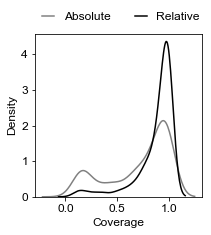

In [75]:
fig, ax = plt.subplots(figsize=(3,3), sharey=True)
sns.kdeplot(newdf["abs_coverage"], color='grey')
sns.kdeplot(newdf["rel_coverage"], color='black')
ax.set_xlabel("Coverage")

plt.legend(['Absolute', 'Relative'], frameon=False,
           bbox_to_anchor=(1.05, 1.2), ncol=2, handlelength=1)
plt.savefig('./plots/FigureS5B.png', dpi=300, bbox_inches='tight')
plt.show()

## D

In [19]:
diso_df = pd.read_csv("../data/misc/disprot_unique_yeast_regions.csv")
diso_df.rename(columns={'region_sequence':'region.seq', 'start':'left.bound', 'end':'right.bound'}, inplace=True)

print("Number of sequences before filtering: {}".format(len(diso_df)))
# Filter out a few examples where disprot sequences is different than msa sequence from aybrah
wrong_seq = []
for index, row in diso_df.iterrows():
    orf = row['orf']
    try:
        msa = AlignIO.read(open(fdir+str(orf)+'-aybrah.fa'), "fasta")
    except ValueError:
        print("{} aybrah file not found; excluding".format(orf))
        wrong_seq.append(index)
    contains_seq = False
    for record in msa:
        seq = crutil.remove_gaps(record.seq)
        if row['region.seq'] in seq:
            contains_seq = True
    if not contains_seq:
        wrong_seq.append(index)
        
diso_df.drop(diso_df.index[wrong_seq], inplace=True)

print("Number of sequences after filtering: {}".format(len(diso_df)))

Number of sequences before filtering: 297
YEL009C aybrah file not found; excluding
YEL009C aybrah file not found; excluding
YMR174C aybrah file not found; excluding
YMR174C aybrah file not found; excluding
YMR174C aybrah file not found; excluding
YMR174C aybrah file not found; excluding
YMR174C aybrah file not found; excluding
YDR363W-A aybrah file not found; excluding
YKL068W aybrah file not found; excluding
YML058W aybrah file not found; excluding
YLR453C aybrah file not found; excluding
YLR453C aybrah file not found; excluding
YNL030W aybrah file not found; excluding
YJL138C aybrah file not found; excluding
YMR212C aybrah file not found; excluding
Number of sequences after filtering: 282


In [24]:
newdisocols = diso_df.apply(get_row_length_props, args=(25,fdir,"-"), axis=1)
newdisocols.columns = ['abs_coverage', 'rel_coverage', 'unfiltered_len_var', 'filtered_len_var']
new_diso_df = diso_df.join(newdisocols)
new_diso_df["label"] = "DisProt"
new_diso_df.head()

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_37139/2211154365.py:18: RuntimeWarning: Degrees of freedom <= 0 for slice.
  std = np.sqrt(np.nanvar(x))
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_37139/2211154365.py:22: RuntimeWarning: Mean of empty slice
  return(std / np.abs(np.nanmean(x)))


,Unnamed: 0,acc,disprot_id,left.bound,right.bound,region.seq,SGID,orf,gene,abs_coverage,rel_coverage,unfiltered_len_var,filtered_len_var,label
0,0,P32774,DP00009,89,104,DSHRDASQNGSGDSQS,S000001541,YKL058W,TOA2,0.000000,0.00,NaN,0.664676,DisProt
1,1,P11938,DP00020,1,123,MSSPDDFETAPAEYVDALDPSMVVVDSGSAAVTAPSDSAAEVKANQ...,S000005160,YNL216W,RAP1,0.454545,0.60,0.677015,1.049330,DisProt
2,2,P11938,DP00020,210,359,YDNFREVVDSRLQEESHSNGVDNSNSNSDNKDSIRPKTEIISTNTN...,S000005160,YNL216W,RAP1,0.575758,0.76,0.435998,0.639638,DisProt
3,4,P11938,DP00020,481,511,ITDEDTPTAIARRNMTMDPNHVPGSEPNFAA,S000005160,YNL216W,RAP1,0.181818,0.24,0.226847,1.595821,DisProt
4,5,P11938,DP00020,594,674,SAAKRARNYSSQRNVQPTANAASANAAAAAAAAASNSYAIPENELL...,S000005160,YNL216W,RAP1,0.636364,0.84,0.588870,0.776721,DisProt


In [28]:
diso_to_plot = new_diso_df[["label", 'region.seq', 'unfiltered_len_var', 'filtered_len_var']]
hits_to_plot = newdf[['label', 'region.seq', 'unfiltered_len_var', 'filtered_len_var']]
to_plot = pd.concat([diso_to_plot,hits_to_plot], axis=0)

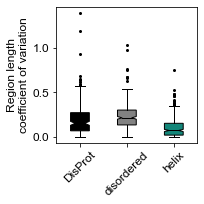

In [29]:
plt.figure(figsize=(3,3))
sns.boxplot(x="label", y = "unfiltered_len_var", hue='label', dodge=False, data = to_plot,
            linewidth=1,
            flierprops={"marker": "o", "markersize": 2},
            notch=True,
            palette=['black', cscheme['dis'], cscheme['helix']], width=0.4)
plt.xlabel(None)
plt.ylabel("Region length\ncoefficient of variation")
plt.legend([], title=None, frameon=False)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.savefig('./plots/FigureS5C.png', dpi=300)
plt.show()